# Preprocessing <a name="preprocessing"></a>

### Import required libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import itertools

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
# import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

### Define a few constants

In [4]:
EPOCHS = 1
VERBOSE = 1
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
RANDOM_SEED = 0

FOLDER_ROOT = './../'
FOLDER_INPUT = FOLDER_ROOT + '/input'
FOLDER_OUTPUT = FOLDER_ROOT + '/output'

# ===========================
# ===========================

IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_DEPTH = 1

INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)

#### Categories / labels

Each training and test example is assigned to one of the following labels:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot 


In [5]:
CATEGORIES = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

### Load data

Let's load the data and split them into features and labels.

_**Please note:** We have labels in the test set because Fashion-MNIST is a public dataset. You will have only features when you are working with competition data._

In [6]:
train = pd.read_csv(FOLDER_INPUT + '/fashion-mnist_train.csv')
test = pd.read_csv(FOLDER_INPUT + '/fashion-mnist_test.csv')

features_train = train.iloc[:, 1:].values
labels_train = train.iloc[:, 0].values

features_test = test.iloc[:, 1:].values
labels_test = test.iloc[:, 0].values

### Reshape the input data



> Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.


In [7]:
features_train = features_train.reshape(len(features_train), IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)
features_test = features_test.reshape(len(features_test), IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH)

features_train = features_train.astype('float32')
features_test = features_test.astype('float32')

features_train /= 255.0
features_test /= 255.0

### Encode the labels

In [8]:
labels_train = to_categorical(labels_train, num_classes=10)
labels_test = to_categorical(labels_test, num_classes=10)

### Split the data

In [9]:
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED)

# Data exploration <a name="data-exploration"></a>

In [10]:
print("There are {} images in the training set".format(np.shape(features_train)[0]))
print("Image shape: {}".format(np.shape(features_train)[1:]))

There are 48000 images in the training set
Image shape: (28, 28, 1)


In [11]:
print("There are {} images in the training set".format(np.shape(features_validation)[0]))
print("Image shape: {}".format(np.shape(features_validation)[1:]))

There are 12000 images in the training set
Image shape: (28, 28, 1)


In [12]:
print("There are {} images in the test set".format(np.shape(features_test)[0]))
print("Image shape: {}".format(np.shape(features_test)[1:]))

There are 10000 images in the test set
Image shape: (28, 28, 1)


In [13]:
classes = np.array(train.iloc[:, 0].values)
unique, counts = np.unique(classes, return_counts=True)

trace = go.Bar(
    x=CATEGORIES,
    y=counts
)

layout = dict(title = 'Number of images / category in the training set',
              xaxis = dict(title = 'Items'),
              yaxis = dict(title = 'Occurence'))

py.iplot(dict(data=[trace], layout=layout))

In [14]:
classes = np.array(test.iloc[:, 0].values)
unique, counts = np.unique(classes, return_counts=True)

trace = go.Bar(
    x=CATEGORIES,
    y=counts
)

layout = dict(title = 'Number of images / category in the test set',
              xaxis = dict(title = 'Items'),
              yaxis = dict(title = 'Occurence'))

py.iplot(dict(data=[trace], layout=layout))

### Samples

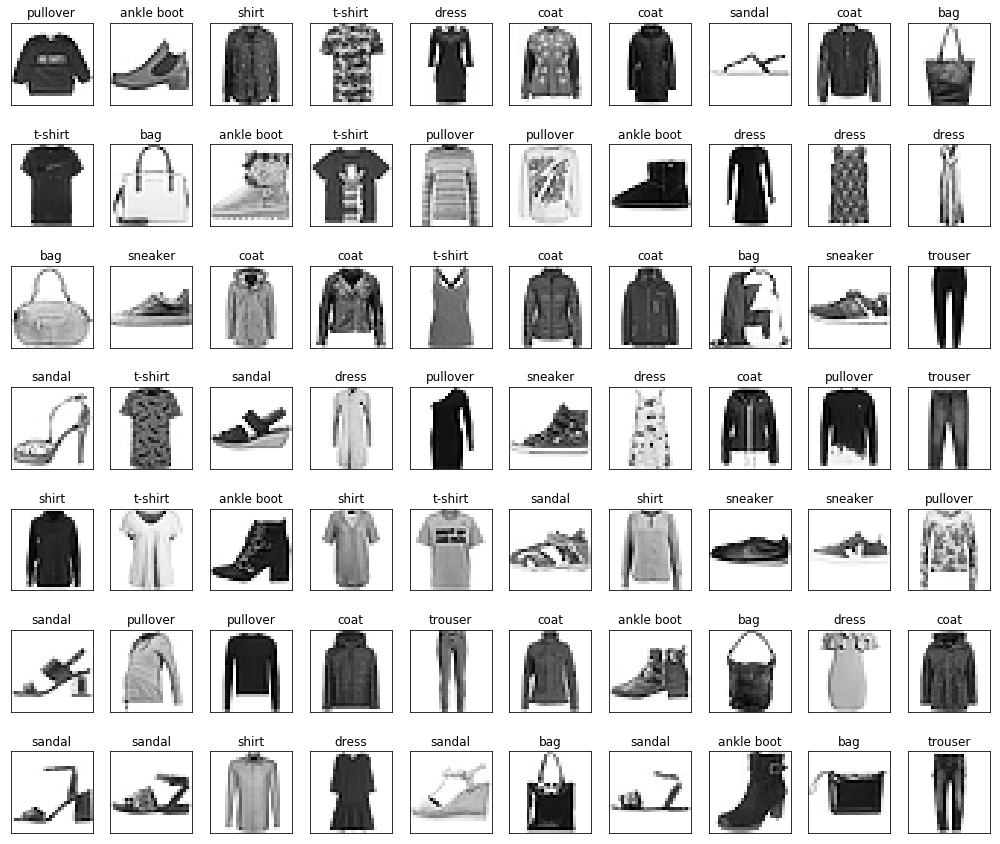

In [15]:
# plot some of the images
plt.figure(figsize=(14, 12))

for i in range(0,70):
    splt = plt.subplot(7, 10, i+1)
    plt.imshow(train.iloc[:, 1:].values[i].reshape(28, 28), cmap="Greys")
    plt.title("{}".format(CATEGORIES[train.iloc[:, 0].values[i]]))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

# CNN - Define the model <a name="cnn-define-the-model"></a>

### Optimizer

In [16]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0., amsgrad=True)

### Callbacks

In [17]:
# Learning Rate reducer
lr_tuner = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=VERBOSE, factor=0.8, min_lr=0.00001)

# Early stop

### Data augmentation

In [18]:
img_generator = ImageDataGenerator(rotation_range=8,
                                   zoom_range=0.08,
                                   shear_range=0.08,
                                   height_shift_range=0.08,
                                   width_shift_range=0.08,
                                   horizontal_flip=True)

img_generator.fit(features_train)

batches = img_generator.flow(features_train, labels_train, batch_size=BATCH_SIZE)

### Keras - Sequential API

In [19]:
km = Sequential()

km.add(Convolution2D(32, (5, 5), input_shape=INPUT_SHAPE, activation='relu', padding='same'))
km.add(BatchNormalization())

km.add(Convolution2D(32, (2, 2), activation='relu', padding='same'))
km.add(BatchNormalization())

km.add(Convolution2D(32, (2, 2), activation='relu', padding='same'))
km.add(MaxPooling2D(pool_size=(2, 2)))
km.add(BatchNormalization())
km.add(Dropout(0.1))

km.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
km.add(BatchNormalization())

km.add(Convolution2D(64, (2, 2), activation='relu', padding='same'))
km.add(MaxPooling2D(pool_size=(2, 2)))
km.add(BatchNormalization())
km.add(Dropout(0.15))

km.add(Flatten())
km.add(BatchNormalization())

km.add(Dense(units=256, activation='relu'))
km.add(BatchNormalization())
km.add(Dropout(0.25))

km.add(Dense(units=128, activation='relu'))
km.add(BatchNormalization())
km.add(Dropout(0.3))

km.add(Dense(units=10, activation='softmax'))

### Compile the model

In [20]:
km.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
km.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4128      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 32)        128       
__________

# Train <a name="train"></a>

In [21]:
history = km.fit_generator(batches,
                           steps_per_epoch=features_train.shape[0] / BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=(features_validation, labels_validation),
                           callbacks=[lr_tuner],
                           verbose=VERBOSE)

Epoch 1/1
750/750 [==============================] - 415s 553ms/step - loss: 0.6259 - acc: 0.7669 - val_loss: 0.6684 - val_acc: 0.7286


### Predict and evaluate

In [22]:
print("Validation Loss: {0:.6f},\nValidation Accuracy: {1:.6f}\n\n".format(
    history.history['val_loss'][-1], history.history['val_acc'][-1]))

# In this dataset we have the correct labels for the tests set too.
test_loss, test_acc = km.evaluate(features_test, labels_test, verbose=VERBOSE)
print("\nTest Loss: {0:.6f},\nTest Accuracy: {1:.6f}\n\n".format(test_loss, test_acc))

Validation Loss: 0.668446,
Validation Accuracy: 0.728583


10000/10000 [==============================] - 27s 3ms/step

Test Loss: 0.663627,
Test Accuracy: 0.729400




In [23]:
predictions = km.predict_classes(features_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

10000/10000 [==============================] - 25s 2ms/step


# Analyze the results <a name="analyze-the-results"></a>

### Accuracy

*Please note: Because of the limitations of the kernel, I hardcoded the accuracy values.*

In [24]:
# Data from local training (20 epochs)
# Note: the learning rate and the augmentation params were a bit different.
plt_epochs = 20
plt_acc = [0.777833333,0.841708333,0.862895833,0.8709375,0.881208333,0.887104167,0.89025,0.892791667,0.895333333,0.900854167,0.901854167,0.903854167,0.9066875,0.909604167,0.910145833,0.911291667,0.915895833,0.914604167,0.917125,0.919333333]
plt_val_acc = [0.801666667,0.885416667,0.871583333,0.905916667,0.895083333,0.9095,0.902916667,0.9215,0.910583333,0.913416667,0.924416667,0.925916667,0.919416667,0.9235,0.922,0.920416667,0.926166667,0.919333333,0.9265,0.930583333,]

In [25]:
# =========================================
# Use these values for your actual results.
# =========================================
# plt_epochs = EPOCHS
# plt_acc = history.history['acc']
# plt_val_acc = history.history['val_acc']

train_trace = go.Scatter(x=np.linspace(0, plt_epochs, plt_epochs),
                         y=plt_acc,
                         name='Training accuracy')

valid_trace = go.Scatter(x=np.linspace(0, plt_epochs, plt_epochs),
                         y=plt_val_acc,
                         name='Validation accuracy')

layout = dict(title = 'Training and Validation Accuracy',
              xaxis = dict(title = 'Epochs (1-20)'),
              yaxis = dict(title = 'Accuracy'))

py.iplot(dict(data=[train_trace, valid_trace], layout=layout))

The validation accuracy after 20 epochs was *0.9306*. It is not remarkably good, but it is a good start. I think it can be improved by tuning the hyperparameters. I could probably achieve a 0.95+ accuracy. For a better result, we will need more sophisticated methods.

In [26]:
# Data from local training (200 epochs)
plt_epochs = 200
plt_acc = [0.773854167,0.837729167,0.8594375,0.870020833,0.874375,0.879666667,0.887979167,0.889604167,0.894416667,0.8955625,0.8996875,0.9025625,0.901770833,0.903541667,0.9058125,0.908875,0.9088125,0.910625,0.914979167,0.915333333,0.914583333,0.916125,0.919041667,0.921020833,0.920479167,0.92225,0.9216875,0.922291667,0.924541667,0.9273125,0.926583333,0.926333333,0.927958333,0.927375,0.927645833,0.929354167,0.930145833,0.9304375,0.93325,0.932333333,0.933354167,0.933333333,0.933291667,0.934145833,0.934458333,0.934354167,0.934625,0.9370625,0.936416667,0.937083333,0.9379375,0.939479167,0.9379375,0.938375,0.939041667,0.938708333,0.938625,0.939166667,0.940416667,0.939770833,0.941041667,0.938416667,0.94,0.941604167,0.938604167,0.94225,0.9401875,0.941625,0.943229167,0.94225,0.9429375,0.942395833,0.942979167,0.9438125,0.945145833,0.943166667,0.94425,0.94425,0.945229167,0.944708333,0.943875,0.944125,0.943583333,0.9451875,0.9459375,0.945291667,0.945041667,0.945166667,0.946875,0.945729167,0.946125,0.946145833,0.946583333,0.945833333,0.946875,0.944270833,0.946479167,0.9469375,0.9469375,0.946104167,0.94675,0.946541667,0.9455625,0.948,0.947041667,0.946375,0.948604167,0.947125,0.946958333,0.946208333,0.9481875,0.9468125,0.94675,0.9491875,0.947375,0.947145833,0.947125,0.947,0.946395833,0.9466875,0.948083333,0.9464375,0.947395833,0.9474375,0.947833333,0.947041667,0.945541667,0.948333333,0.946208333,0.948791667,0.948166667,0.948145833,0.948208333,0.948333333,0.948625,0.945958333,0.947895833,0.948291667,0.947104167,0.9479375,0.947020833,0.9473125,0.947729167,0.948208333,0.947145833,0.94875,0.946854167,0.947520833,0.947458333,0.947770833,0.946416667,0.948416667,0.948416667,0.947895833,0.949604167,0.947208333,0.947375,0.9483125,0.948604167,0.947083333,0.948541667,0.9469375,0.948375,0.948729167,0.948083333,0.947,0.9465,0.946270833,0.9483125,0.9470625,0.9484375,0.9485,0.948520833,0.948666667,0.947104167,0.948270833,0.94775,0.947916667,0.948541667,0.94675,0.946333333,0.948229167,0.947625,0.947854167,0.948625,0.947083333,0.947770833,0.948354167,0.947895833,0.947583333,0.947041667,0.947833333,0.948104167,0.947916667,0.947458333,0.94825,0.947895833,0.949208333,0.947479167,0.947645833]
plt_val_acc = [0.726416667,0.843416667,0.886583333,0.885166667,0.803666667,0.887833333,0.903916667,0.907083333,0.892666667,0.913916667,0.926416667,0.914916667,0.87325,0.91525,0.900833333,0.93,0.917416667,0.929666667,0.90325,0.899333333,0.924666667,0.9215,0.930166667,0.93075,0.9245,0.9315,0.933833333,0.929416667,0.934333333,0.9355,0.934083333,0.934,0.924083333,0.933916667,0.918333333,0.93475,0.937833333,0.9375,0.93675,0.93325,0.931916667,0.9405,0.939083333,0.934,0.937333333,0.937916667,0.93675,0.928,0.930166667,0.934083333,0.9385,0.939083333,0.938583333,0.929666667,0.93975,0.937416667,0.934833333,0.938833333,0.93825,0.9355,0.935833333,0.938416667,0.93975,0.938583333,0.939166667,0.938333333,0.938,0.93275,0.94,0.934916667,0.940666667,0.94075,0.940083333,0.938166667,0.939666667,0.938666667,0.941666667,0.939,0.938083333,0.938583333,0.938666667,0.936916667,0.940333333,0.939333333,0.94025,0.94025,0.942333333,0.938416667,0.941083333,0.940583333,0.937666667,0.93925,0.94075,0.941833333,0.939583333,0.94,0.94125,0.93975,0.940083333,0.940833333,0.941,0.94,0.940083333,0.941416667,0.94175,0.941916667,0.94075,0.939833333,0.93975,0.9415,0.939916667,0.939833333,0.940916667,0.940083333,0.939666667,0.94075,0.94075,0.941083333,0.94075,0.940833333,0.941166667,0.94125,0.941,0.941333333,0.941,0.940583333,0.940916667,0.94125,0.941333333,0.94125,0.940333333,0.940666667,0.941,0.94075,0.941083333,0.9405,0.940916667,0.941166667,0.94075,0.940416667,0.940666667,0.9405,0.941083333,0.940833333,0.940416667,0.940666667,0.94075,0.9405,0.941,0.940416667,0.941083333,0.940833333,0.941,0.941083333,0.94125,0.940666667,0.940666667,0.940416667,0.94125,0.941,0.940666667,0.940583333,0.940583333,0.941083333,0.941,0.94125,0.940666667,0.941333333,0.941166667,0.9415,0.94075,0.940833333,0.941083333,0.940666667,0.941333333,0.941,0.940583333,0.940666667,0.94075,0.941083333,0.940916667,0.941166667,0.941166667,0.940916667,0.94075,0.941,0.940916667,0.94075,0.940916667,0.940916667,0.94125,0.940916667,0.941166667,0.941166667,0.941,0.94075,0.941,0.940916667,0.941,0.940666667]

In [27]:
train_trace = go.Scatter(x=np.linspace(0, plt_epochs, plt_epochs),
                         y=plt_acc,
                         name='Training accuracy')

valid_trace = go.Scatter(x=np.linspace(0, plt_epochs, plt_epochs),
                         y=plt_val_acc,
                         name='Validation accuracy')

layout = dict(title = 'Training and Validation Accuracy',
              xaxis = dict(title = 'Epochs (1-200)', range=(5, 180)),
              yaxis = dict(title = 'Accuracy', range=(.87, .96)))

py.iplot(dict(data=[train_trace, valid_trace], layout=layout))

#### Overfitting

As you can see, there is a bit of overfitting. After 90-100 epochs the accuracy did not improve anyway, I should have added an EarlyStopping callback to the model. There is no point to train more than 70-75 iterations.

### Classification report (test set)

*In this Notebook, I've trained the model for only 1 epoch. The report was generated based on that.*

In [28]:
target_names = ["{}".format(i) for i in CATEGORIES]
print(classification_report(test.iloc[:, 0].values, predictions, target_names=target_names))

             precision    recall  f1-score   support

    t-shirt       0.99      0.29      0.45      1000
    trouser       0.99      0.97      0.98      1000
   pullover       0.94      0.20      0.32      1000
      dress       0.69      0.96      0.80      1000
       coat       0.71      0.49      0.58      1000
     sandal       0.78      0.99      0.87      1000
      shirt       0.34      0.85      0.49      1000
    sneaker       0.98      0.66      0.79      1000
        bag       0.97      0.95      0.96      1000
 ankle boot       0.90      0.94      0.92      1000

avg / total       0.83      0.73      0.72     10000



Not too good, not too bad.

**Precision**: of all items that labeled as *pullover*, how many actually *pullover*? 64%  
**Recall**: of all the *shirts*, how many did we label? 19%

Let's look at it in more detail.

### Confusion Matrix (test set)

In [29]:
cm = confusion_matrix(test.iloc[:, 0].values, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

layout = dict(title = 'Confiusion Matrix (test set)',
              xaxis = dict(title = 'Predicted labels'),
              yaxis = dict(title = 'True labels'),
              width = 600,
              height = 600
             )

trace = go.Heatmap(x0=1, x=CATEGORIES, y=CATEGORIES, z=cm, colorscale=[[0.0, '#0d47a1'], [1.0, '#bbdefb']])
py.iplot(dict(data=[trace], layout=layout))

The model cannot distinguish the shirt/t-shirt/pullover/coat. It is better after 20-30-40 iteration, but there is lots of room to improve.

### Incorrect predictions (test set)

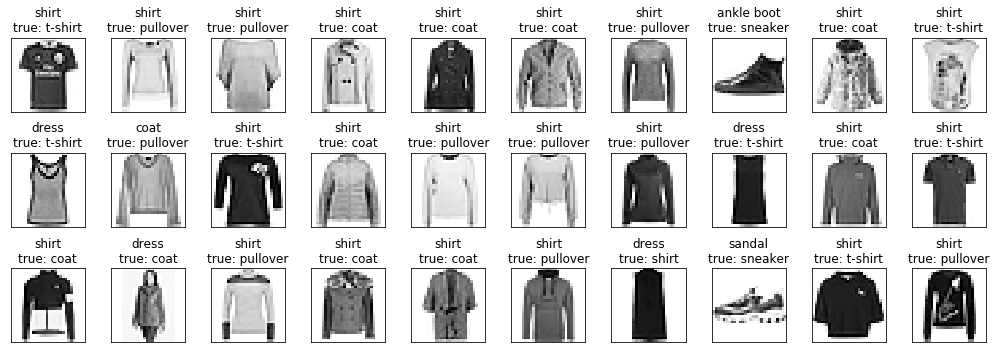

In [30]:
incorrect = np.nonzero(predictions != test.iloc[:, 0].values)[0]

plt.figure(figsize=(14, 5))

for i, incorrect in enumerate(incorrect[0:30]):
    splt = plt.subplot(3, 10, i+1)
    plt.imshow(test.iloc[:, 1:].values[incorrect].reshape(28, 28), cmap="Greys")
    plt.title("{}\ntrue: {}".format(CATEGORIES[predictions[incorrect]], CATEGORIES[test.iloc[:, 0].values[incorrect]]))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

# Further improvement 

I have a few idea how to improve the model.

- Fine-tune the parameters
- Run this model multiple times and ensemble (majority vote) the results to reduce overfit and improve the accuracy.
- Create/train binary classificaiton models (eg: is it shirt or not?) and combine with this one.
- Create new datasources (eg: 24px, 20px, 16px, etc), retrain and ensemble everything together.

